# Random Forrest --- predict Failure Mode #
# UCI dataset "AI4I 2020 Predictive Maintenance Dataset Data Set" #

Online-Source [here](https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset#)

 AI4I 2020 Predictive Maintenance Dataset Data Set
Download: Data Folder, Data Set Description

Abstract: The AI4I 2020 Predictive Maintenance Dataset is a synthetic dataset that reflects real predictive maintenance data encountered in industry.

| | | | | | |	
|:---|:---:|:---|:---:|:---|:---:|
|Data Set Characteristics: |Multivariate, Time-Series |Number of Instances: |10.000 |Area: |Computer |
|Attribute Characteristics: |Real |Number of Attributes: |14 | Date Donated: | 2020-08-30 |
|Associated Tasks: | Classification, Regression, Causal-Discovery | Missing Values? |N\A|Number of Web Hits: | 16614 |


Source:

Stephan Matzka, School of Engineering - Technology and Life, Hochschule für Technik und Wirtschaft Berlin, 12459 Berlin, Germany, stephan.matzka '@' htw-berlin.de

Data Set Information:

Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, we present and provide a synthetic dataset that reflects real predictive maintenance encountered in industry to the best of our knowledge.




Attribute Information:

The dataset consists of 10 000 data points stored as rows with 14 features in columns <br>
<b> UID : </b> unique identifier ranging from 1 to 10000<br>
<b> product ID: </b>consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number <br>
<b> air temperature [K]: </b> generated using a random walk process later normalized to a standard deviation of 2 K around 300 K <br>
<b> process temperature [K]: </b> generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K. <br>
<b> rotational speed [rpm]: </b> calculated from a power of 2860 W, overlaid with a normally distributed noise <br>
<b> torque [Nm]: </b> torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values. <br>
<b> tool wear [min]: </b> The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true. <br>

The machine failure consists of five independent failure modes <br>
<b> tool wear failure (TWF): </b> the tool will be replaced or fail at a randomly selected tool wear time between 200 â€“ 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned). <br>
<b> heat dissipation failure (HDF): </b> heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the toolâ€™s rotational speed is below 1380 rpm. This is the case for 115 data points. <br>
<b> power failure (PWF): </b> the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset. <br>
<b> overstrain failure (OSF): </b> if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints. <br>
<b> random failures (RNF): </b> each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.<br>
<br>
If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail

Relevant Papers:

Stephan Matzka, 'Explainable Artificial Intelligence for Predictive Maintenance Applications', Third International Conference on Artificial Intelligence for Industries (AI4I 2020), 2020 (in press)


Citation Request:

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. 

# <b> What is done in this notebook? </b> #
Every data record contains information on the failure and the failure mode.
In this notebook we try to predict, which failure mode applies to a given record.

To this end we chose a subset of features of the dataset and use:
1. a decisiontree 
2. a random forrest

## Plan: ##
1. enhance the failue modes by a new one: NOF - no failure. Thus a predictor has the possibility to move probability mass to this mode in case of no failure.
2. construct a random forrest 
3. determine the best size of the forrest measured by AUC


# Accuracy is not the correct metric #
Machine failure is a rare event, i.e. accuracy is no meaningful performace-measure since a classifier allways predicting "No Machine Failure" will have a high accurcy without being usefull at all.<br>
We use:<br>
+ AUC area under (ROC) curve ---


In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np

In [2]:
# READ THE DATASET INTO A DATAFRAME:
# ==================================

# use absolute path:

#base_path = Path("C:/Users/BoSc/Documents/1000_Machine_Learning/1000_UCI_datasets/predictive_maintenance_dataset")
#csv_data_file_path = Path("/dataset/ai4i2020.csv")
#df = pd.read_csv(os.path.join(base_path, csv_data_file_path))

# use path relative to the notebook:

csv_data_file_path = Path("./dataset/ai4i2020.csv")
df = pd.read_csv(csv_data_file_path)

In [3]:
# TAKE A LOOK AT THE DATA:
# ========================

print(df.head(2))

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  


In [4]:
# start by dealing with only one quality of equipment: l or h or m:
#==================================================================
equipment_type = 'L'
#equipment_type = 'M'
#equipment_type = 'H'
df_ = df[df['Type']=='L']
df_

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,9989,L57168,L,298.9,308.6,1771,24.1,213,0,0,0,0,0,0
9990,9991,L57170,L,298.8,308.5,1527,36.2,3,0,0,0,0,0,0
9992,9993,L57172,L,298.8,308.4,1484,39.2,8,0,0,0,0,0,0
9993,9994,L57173,L,298.8,308.4,1401,47.3,10,0,0,0,0,0,0


In [5]:
# SELECT COLUMNS THAT HAVE A SAY IN THE PREDICTION:
# ==================================================

data_columns = [
    'Air temperature [K]','Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]',
    'Machine failure',
    'TWF',
    'HDF', 
    'PWF', 
    'OSF',
    'RNF',
    ]
data_df = df_[data_columns]
print(f"\n {data_df.head(2)}")


    Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   

   Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  RNF  
1         46.3                3                0    0    0    0    0    0  
2         49.4                5                0    0    0    0    0    0  


In [6]:
data_df.shape

(6000, 11)

In [7]:
data_df.head()


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
6,298.1,308.6,1558,42.4,14,0,0,0,0,0,0


In [8]:
# PREPARE DATA AND LABELS:
# ========================

from sklearn.model_selection import train_test_split

predictive_columns = data_columns[:-6]
X = data_df[predictive_columns]
target_columns = data_columns[-6:]
y = data_df[target_columns]
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0, test_size=0.2)
print(X.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6000, 5)
(6000, 6)
(4800, 5)
(4800, 6)
(1200, 5)
(1200, 6)


# Decision Tree: #

In [9]:
# DEFINE AND FIT DECISION-TREE:
# =============================

from sklearn.tree import DecisionTreeClassifier

max_graph_depth=6
tree_clf = DecisionTreeClassifier(max_depth=max_graph_depth)
tree_clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=6)

In [10]:
# MEAN ACCURACY OF THE TEST DATA:
# ===============================

# this does not say much, since we have mainly "0" as labels:
print(f"\n Mean accuracy: {tree_clf.score(X_test, y_test)}")


 Mean accuracy: 0.9708333333333333


In [11]:
# ROC-AUC METRIC FOR DATASET WITH CLASS IMBALANCE:

# Data School vid on roc auc: https://youtu.be/OAl6eAyP-yo

from sklearn.metrics import roc_auc_score

y_score = tree_clf.predict(X_test)
auc=roc_auc_score(y_test, y_score)
print(f"\n Area Under the Curve (auc): {auc}")


 Area Under the Curve (auc): 0.6526625908204856


# Visualize the decision-tree as a graph: #
1. Run the next cell: a file will be saved in your folder named "machine_tree_depth{max_graph_depth}.dot". 
2. Open this file in Microsoft Word or in VSCode or Notepad++ and copy all of its content. 
3. Open the browser, type "webgraphviz", click on the first link - or use [this](http://www.jdolivet.byethost13.com/Logiciels/WebGraphviz/?i=1)

4. Delete whatever is written in white space and paste the copied content from step 2.
5. Click "generate graph". 
5. Scroll down to find the graph: left mouse button "take screen-shot" -> paste into irfan view-> safe as .jpg in the project folder

6. Either display the jpg inside the notebook or open (double-click) inside VS Code (opens in new tab).

In [12]:
# the following code can be used to generate a visualisation of the decisiontree as a graph - see preceding text:


from sklearn.tree import export_graphviz

out_file_name=f"machine_tree_depth{max_graph_depth}"

export_graphviz( 
    tree_clf,
    out_file=out_file_name,
    feature_names=predictive_columns,
    class_names=["No Machine Failure", "Machine Failure"],
    rounded= True,
    filled=True
    )

# Random Forrest Classifier: #

In [13]:
# Random Forrest Classifier:
#==============================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

n_estimators = []

def rf_auc(n_estimators, X_train, y_train, y_test):
    """
        The function trains a random-forrest for each number of trees given in the n_estimators list and determines it's auc-score on the X_test set.
        Input:
            n_estimators: a list of numbers specifying the number of estimators (trees) in the forrests.
        Output:
            a list of auc - scores for the forrests, trained with the respective number of trees
            a list of acccuracies - accuracies of the forrests
            (test_targets, predicted_targets) - a pair of lists containing the test targets and the corresponding prediction of the respective forrests.

    """
    aucs=[]
    accuracies=[]
    for nofest in n_estimators:
        rnd_clf = RandomForestClassifier(n_estimators=nofest, max_leaf_nodes=None, n_jobs=-1)
        rnd_clf.fit(X_train,y_train)
        y_pred_rf = rnd_clf.predict(X_test)
        aucs.append(roc_auc_score(y_test.values, y_pred_rf))
        accuracies.append(rnd_clf.score(X_test, y_test.values))
    return aucs, accuracies, (y_test.values, y_pred_rf)

# compare with the single decision-tree of the previous solution above:
auc, acc, (truth,preds) = rf_auc([300],  X_train, y_train, y_test)
print(f"\n Equipment Type: {equipment_type}")
print(f"\n auc: {auc}")
print(f"\n accuracy: {acc}")
#for i in range(len(truth)):
#    if( truth[i].sum() > 0 or preds[i].sum() > 0):
#        print(f"\n {truth[i]} -- {preds[i]}")


 Equipment Type: L

 auc: [0.7346466572667946]

 accuracy: [0.98]

 [1 0 0 1 0 0] -- [1 0 0 1 0 0]

 [1 0 0 0 1 0] -- [1 0 0 0 1 0]

 [1 0 0 0 1 0] -- [1 0 0 0 1 0]

 [1 0 0 1 0 0] -- [1 0 0 1 0 0]

 [1 0 0 1 0 0] -- [0 0 0 0 0 0]

 [0 0 0 0 0 1] -- [0 0 0 0 0 0]

 [1 0 0 0 1 0] -- [1 0 0 0 1 0]

 [1 0 0 0 1 0] -- [0 0 0 0 0 0]

 [1 0 0 0 1 0] -- [1 0 0 0 1 0]

 [1 0 0 0 1 0] -- [0 0 0 0 0 0]

 [1 0 1 0 0 0] -- [1 0 1 0 0 0]

 [1 0 1 0 0 0] -- [1 0 1 0 0 0]

 [0 0 0 0 0 1] -- [0 0 0 0 0 0]

 [1 0 0 1 0 0] -- [1 0 0 1 0 0]

 [1 1 0 0 0 0] -- [0 0 0 0 0 0]

 [1 0 1 0 0 0] -- [1 0 1 0 0 0]

 [1 0 1 0 0 0] -- [1 0 1 0 0 0]

 [1 0 0 0 1 0] -- [0 0 0 0 0 0]

 [1 0 1 0 1 0] -- [1 0 1 0 1 0]

 [1 0 1 0 0 0] -- [1 0 1 0 0 0]

 [1 0 1 0 0 0] -- [1 0 1 0 0 0]

 [1 0 0 0 1 0] -- [1 0 0 0 1 0]

 [1 0 1 0 0 0] -- [1 0 0 0 0 0]

 [1 0 0 0 1 0] -- [0 0 0 0 0 0]

 [1 1 0 0 0 0] -- [0 0 0 0 0 0]

 [1 0 0 0 1 0] -- [0 0 0 0 0 0]

 [1 0 0 0 1 0] -- [1 0 0 0 1 0]

 [1 0 1 0 0 0] -- [0 0 0 0 0 0]

 [1 0 1 

In [14]:
# Try to find the best number of estimators:
#===========================================
import numpy as np

n_estimators = np.arange(100, 1000, 100)

xp = n_estimators
aucs, accs, _ = rf_auc(n_estimators, X_train, y_train, y_test)
yp = np.array(aucs)
zp = np.array(accs)


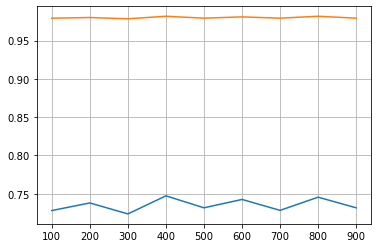

In [15]:
# Plot the auc-scores over every number of trees in n_estimators:
#================================================================
import matplotlib.pyplot as plt 

plt.plot(xp, yp)
plt.plot(xp, zp)
plt.grid()
plt.show()

In [16]:
# find the best choice for the number of estimators by calculation:
#==================================================================
best_nof_estimators = n_estimators[np.argmax(yp)]
best_accuracy = np.max(zp)
worst_accuracy = np.min(zp)
accuracy_for_best_estimator = zp[np.argmax(yp)]
print(f"max auc: {np.max(yp)}, with {best_nof_estimators} estimators, having accuracy of: {accuracy_for_best_estimator} ")
print(f"\nbest_accuracy: {best_accuracy}, worst_accuracy: {worst_accuracy}")

max auc: 0.7472392498593873, with 400 estimators, having accuracy of: 0.9816666666666667 

best_accuracy: 0.9816666666666667, worst_accuracy: 0.9783333333333334


## Summary: ##
1. The number of estimators in the best random-forrest is not a constant, maybe due to the random feature selection in the decision-tree algorithm used by scikit.
2. The auc of the random-forrest is higher than the auc of a single decision tree.
3. The best and the worst accuracy are almost identical, proving once more, that accuracy is not usefull in this heavily unbalanced data-set.
4. The best random-forrest measured by auc is not necessarily the best measured by accuracy.


In [27]:
# training once again with the best number of estimators:
#========================================================
rnd_clf = RandomForestClassifier(n_estimators=400, max_leaf_nodes=None, n_jobs=-1)
rnd_clf.fit(X_train,y_train)
y_pred_rf = rnd_clf.predict(X_test)


In [29]:
# plot a multi-label confusion matrix:
#======================================

from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
cm = multilabel_confusion_matrix(y_test.values, y_pred_rf)
print(cm)
#disp = ConfusionMatrixDisplay(confusion_matrix = cm)
#disp.plot()


[[[1149    1]
  [  14   36]]

 [[1196    0]
  [   4    0]]

 [[1182    0]
  [   3   15]]

 [[1189    0]
  [   3    8]]

 [[1180    1]
  [   6   13]]

 [[1196    0]
  [   4    0]]]


In [104]:
# plot a confusion matrix:
#==========================

# build a mode dictionary for the standard failure modes (given in the explantion above). 
# No multi-mode failures are accounted for:

modes = {"".join(map(str,[0,0,0,0,0,0])): 'No Machine failure',
    "".join(map(str,[1,1,0,0,0,0])):'TWF',
    "".join(map(str,[1,0,1,0,0,0])):'HDF', 
    "".join(map(str,[1,0,0,1,0,0])):'PWF', 
    "".join(map(str,[1,0,0,0,1,0])):'OSF',
    "".join(map(str,[0,0,0,0,0,1])):'RNF',}

# machine failures consisting of multiple modes are designated as "NonStandardMode":

true_modes = []
for v in y_test.values:
    true_modes.append(modes.get("".join(map(str,v)), "NonStandardMode"))

# multi-mode predictions and faulty predictions are counted ass "NonStandardMode":

pred_modes = []
for v in y_pred_rf:
    pred_modes.append(modes.get("".join(map(str,v)), "NonStandardMode"))

['No Machine failure', 'No Machine failure', 'No Machine failure', 'No Machine failure', 'No Machine failure']


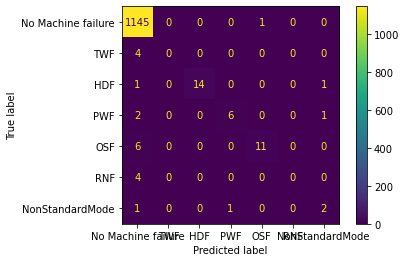

In [111]:
# plotting the actual confusion-matrix:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = ['No Machine failure','TWF','HDF','PWF','OSF','RNF',"NonStandardMode"]
cm = confusion_matrix(true_modes, pred_modes, labels = labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
